<a href="https://colab.research.google.com/github/LongNguyen1984/AFE4300-Arduino/blob/master/ConditionalGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SETUP

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from tensorflow.keras.layers import (
      Activation, BatchNormalization, Concatenate, Dense,
      Embedding, Flatten, Input, Multiply, Reshape
)

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [28]:
# Model input dimensions
img_rows = 28
img_cols = 28
channels = 1

# input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

num_classes = 10


## CGAN GENERATOR

1. Take label y and turn into a dense vector of size z_dim
2. Combine the label embedding with the noise vector z into a joint representation
3. Feed the resulting vector as input into the rest of CGAN Generator network

In [29]:
# CGAN Generator
def build_generator(z_dim):
  model = Sequential()

# Reshape input into a 7*7*256 tensor via a fully connected layers
  model.add(Dense(256*7*7, input_dim = z_dim))
  model.add(Reshape((7,7,256)))
  
  # Transpose convolution layer into a 14*14*128 tensor
  model.add(Conv2DTranspose(128, kernel_size= 3, strides=2, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  
  # Transpose conv-layer to 14*14*64
  model.add(Conv2DTranspose(64, kernel_size= 3, strides= 1, padding='same'))
  # Batch normalization
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # Transpose conv-layer to 28*28*1
  model.add(Conv2DTranspose(1, kernel_size= 3, strides= 2, padding='same'))
  # Output layer with tanh activation
  model.add(Activation('tanh'))

  return model


In [30]:
def build_cgan_generator(z_dim):
  # Generate random noise vector z
  z = Input(shape=(z_dim, ))
  # Conditioning label: integer 0-9 specifying the number G should generate
  label = Input(shape=(1, ), dtype ='int32')

  # Label embedding: turns labels into dense vectors of size z_dim;
  # produces 3D tensor with shape (batch_size, 1, z_dim)
  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

  # Flattens the embedding 3D tensor into 2S tensor with shape (batch_size, z_dim)
  label_embedding = Flatten()(label_embedding)
  # Element-wise product of the vectors z and the label embeddings
  joined_representation = Multiply()([z, label_embedding])

  generator = build_generator(z_dim)
  # Generates image for the ginve label
  conditioned_img = generator(joined_representation)
  return Model([z,label], conditioned_img)

## CGAN DISCRIMINATOR
1. Take a label (an integer from 0 to 9) and-using the Keras Embedding layer-turn the label into a dense vector of size 28x28x1
2. Rehsape the label embedding into the image (28x28x1)
3. Concatenate the reshaped label onto the corresponding image
creating a joint representation with the shape (28x28x2)
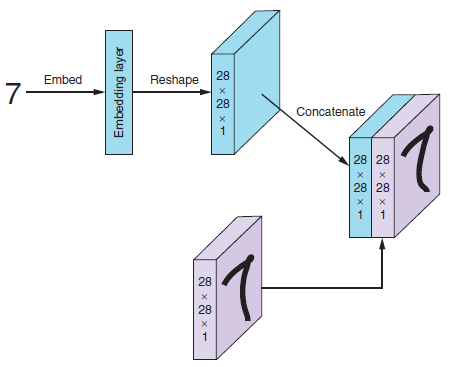

In [31]:
def build_discriminator(img_shape):

  model = Sequential()
  # Conv-layer from 28x28x2 into 14x14x64 tensor
  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2]+1), padding='same'))
  # LeakyReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Conv-layer from 14x14x64 into 7x7x64 tensor
  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  # Batch Normalization
  model.add(BatchNormalization())
  # LeakyReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Conv-layer from 7x7x64 into 3x3x128 tensor
  model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
  # Batch Normalization
  model.add(BatchNormalization())
  # LeakyReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Output layer with sigmoid activation
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

In [32]:
def build_cgan_discriminator(img_shape):
  #input image
  img = Input(shape=img_shape)

  #Label for the input image
  label = Input(shape=(1,), dtype='int32')

  # Label embedding: turn labels into dense vectors of size z_dim; produce 3D tensor with shape (batch_size, 28x28x1)
  label_embedding = Embedding(num_classes,np.prod(img_shape), input_length=1)(label)

  # Flattens the embedding 3D tensor into a 2D tensor with shape (batch_size, 28x28x1)
  label_embedding = Flatten()(label_embedding)

  # Reshapes label embeddings to have the same dimensions as input images
  label_embedding = Reshape(img_shape)(label_embedding)

  # Concatenates images with their label embeddings
  concatenated = Concatenate(axis=-1)([img, label_embedding])

  discriminator = build_discriminator(img_shape)
  # Classifies the image-label pair
  classification = discriminator(concatenated)

  return Model([img, label], classification)

### Build and Compiling the CGAN model

In [33]:
def build_cgan(generator, discriminator):
  # Random the noize vector z
  z = Input(shape=(z_dim, ))

  # Image Label
  label = Input(shape=(1,))

  # Generated image for that label
  img = generator([z, label])

  classification = discriminator([img, label])
  # Combined Generator -> Dicriminator model
  ### G([z,label]) = x*, D(x*) = classification
  model = Model([z,label], classification)

  return model
# BUild and compiles the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keeps Discriminator's parameters constant for Generator training
discriminator.trainable = False
# Builds and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [34]:
# Training
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
  # Load the MNIST dataset
  (X_train, y_train), (_, _) = mnist.load_data()

  ## Rescale [0, 255] to [-1, 1]
  X_train = X_train/127.5 -1.
  X_train = np.expand_dims(X_train, axis=3)

  # Label for real images: all 1s
  real = np.ones((batch_size, 1))
  # Label for fake images: all 0s
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    # Get a random batch of real images and their labels
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Generates a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])

    # Trains the Discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

    # Generate a batch of noise vectors
    z = np.random.normal(0, 1, (batch_size, z_dim))
    # Get a bacthc of random labels
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1,1)

    # Train the Generator
    g_loss =cgan.train_on_batch([z, labels], real)
    
    if (iteration + 1) % sample_interval == 0:
      print('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (iteration + 1, d_loss[0], 100*d_loss[1], g_loss))
      losses.append((d_loss[0], g_loss))
      accuracies.append(100*d_loss[1])

      sample_images()



### Output sample images

In [35]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
  # sample random noise 
  z = np.random.normal(0,1, (image_grid_rows*image_grid_columns, z_dim))
  # Gets image labels 0-9
  labels = np.arange(0, 10).reshape(-1,1)
  # Generates images from random noise
  gen_imgs = generator.predict([z, labels])

  # Rescales image pixel values to [0,1]
  gen_imgs = 0.5*gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(10,4),
                          sharey=True,
                          sharex=True)
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt,:,:, 0], cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title('Digit: %d' % labels[cnt])
      cnt +=1

### TRAIN THE MODEL

1000 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.085913]
2000 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.009179]
3000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.003761]
4000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.002040]
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001617]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000985]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001680]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000446]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000711]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.356776]
11000 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.001411]
12000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000084]


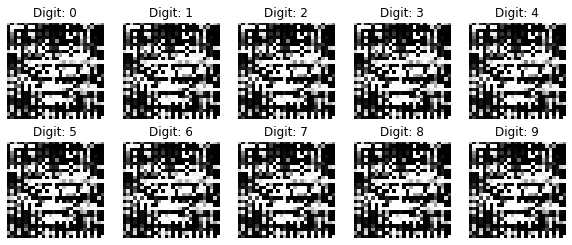

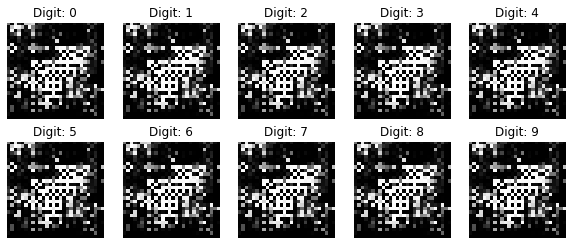

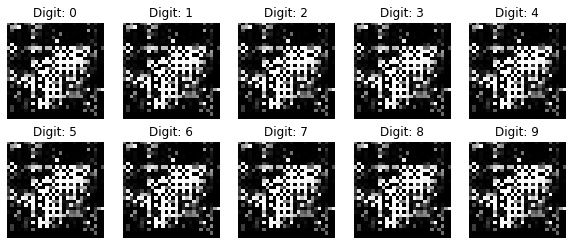

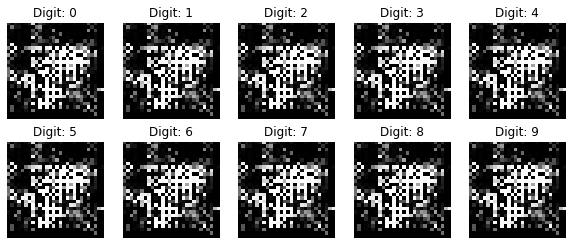

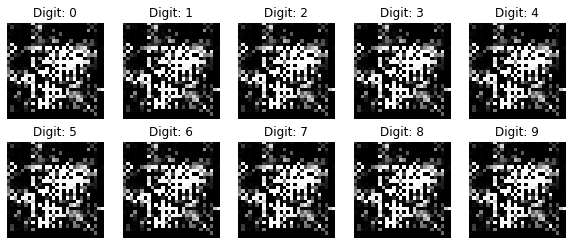

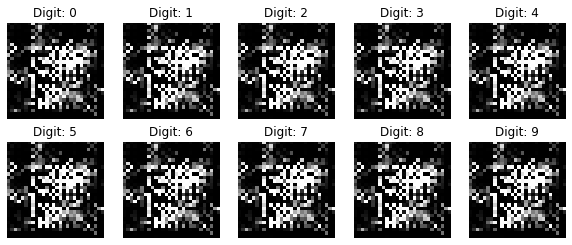

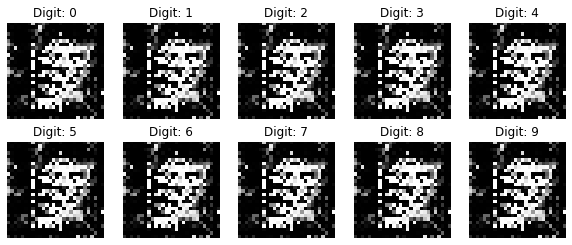

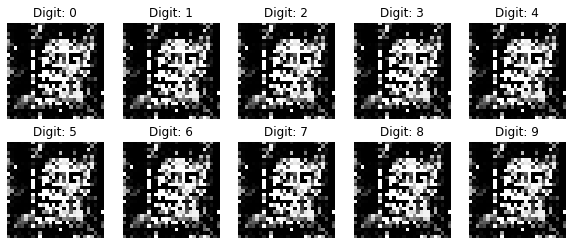

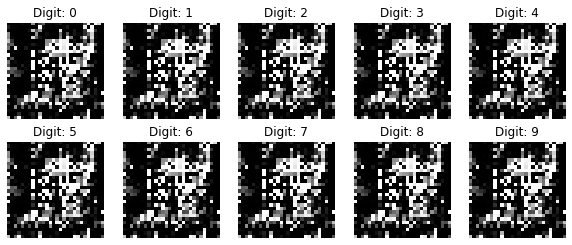

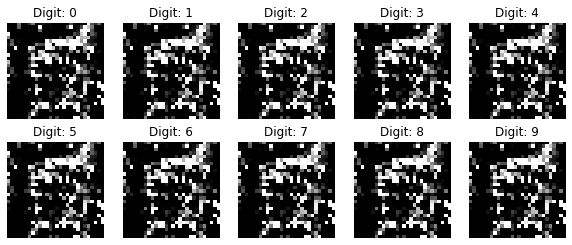

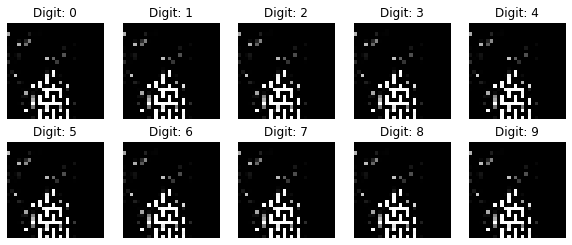

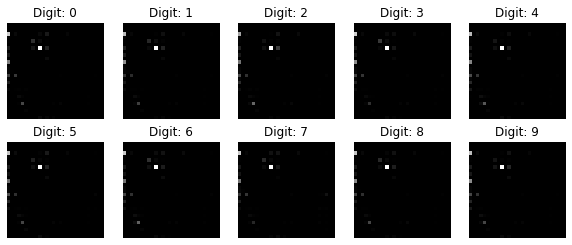

In [45]:
interations = 12000
batch_size = 32
sample_interval = 1000

train(interations, batch_size, sample_interval)

Output from a train CGAN model

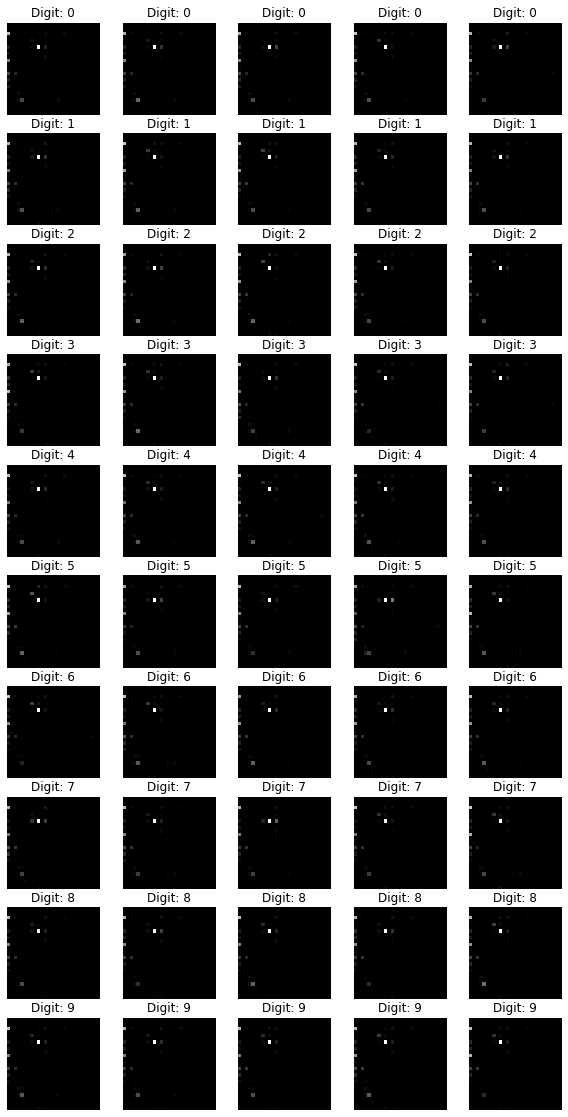

In [46]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1

#Reference

In [37]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

In [38]:
def build_cgan_generator(z_dim):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Conditioning label: integer 0-9 specifying the number G should generate
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, z_dim)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)

    # Element-wise product of the vectors z and the label embeddings
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # Generate image for the given label
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

In [39]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x2 into 14x14x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x64 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [40]:
def build_cgan_discriminator(img_shape):

    # Input image
    img = Input(shape=img_shape)

    # Label for the input image
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)

    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)

    # Concatenate images with their label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    # Classify the image-label pair
    classification = discriminator(concatenated)

    return Model([img, label], classification)

In [41]:
def build_cgan(generator, discriminator):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Image label
    label = Input(shape=(1, ))

    # Generated image for that label
    img = generator([z, label])

    classification = discriminator([img, label])

    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)

    return model

In [42]:
# Build and compile the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())


In [43]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images and their labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of noise vectors
        z = np.random.normal(0, 1, (batch_size, z_dim))

        # Get a batch of random labels
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Train the Generator
        g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # Output sample of generated images
            sample_images()

In [44]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    labels = np.arange(0, 10).reshape(-1, 1)

    # Generate images from random noise
    gen_imgs = generator.predict([z, labels])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1